<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left">DISCOVERY DE LAS NUEVAS VARIABLES</h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquete de manipulación de fechas
import datetime as dt

## Importar DataSet  
Una vez que generadas las nuevas variables, vamos a realizar un pequeño estudio descriptivo sobre ellas. Para ello, importamos el dataset con las nuevas variables:

In [2]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [3]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'df_new_var.csv',Filename = '/tmp/df_new_var.csv')

In [4]:
#Leemos el fichero y lo metemos en un dataframe.
df = pd.read_csv('/tmp/df_new_var.csv', dtype={'rank':'category'})

In [5]:
df.shape

(6362620, 18)

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,week,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0,1,1,0,1,9839.64,0.0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0,1,1,0,1,1864.28,0.0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0,1,1,0,0,181.00,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0,1,1,0,0,181.00,-21182.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0,1,1,0,1,11668.14,0.0,1


In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'day', 'week', 'isFlaggedFraud_New', 'ind_merchant',
       'balanceOrig', 'balanceDest', 'hours_day'],
      dtype='object')

In [7]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/df_new_var.csv

## Análisis de las nuevas variables  
En primer lugar, tomamos sensibilidad del dataframe de trabajo:

In [8]:
print("Tamaño dataset del dataset:", df.shape)
print("Número de variables/predictores (columnas):", df.shape[1])
print("Número de registros (instancias/filas):", df.shape[0])

Tamaño dataset del dataset: (6362620, 18)
Número de variables/predictores (columnas): 18
Número de registros (instancias/filas): 6362620


El nuevo dataframe contiene 19 columnas. Hemos agregado 8 nuevas columnas: *day*, *week*, *hours_day*, *isFlaggedFraud_New*, *ind_merchant*, *balanceOrig*, *balanceDest* y *amount_category*.  A continuación realizamos un análisis descriptivo sobre los datos:

### Análisis descriptivo sobre las variables de tiempo  
Una vez generadas las nuevas variables sobre el dataframe inicial, vamos a elaborar un análisis descriptivo con las variables de tiempo con la intención de analizar el comportamiento de las transacciones durante el período de estudio.  

**¿Cómo se distribuye el volumen de transacciones fraudulentas y no fraudulentas en los días del mes?**

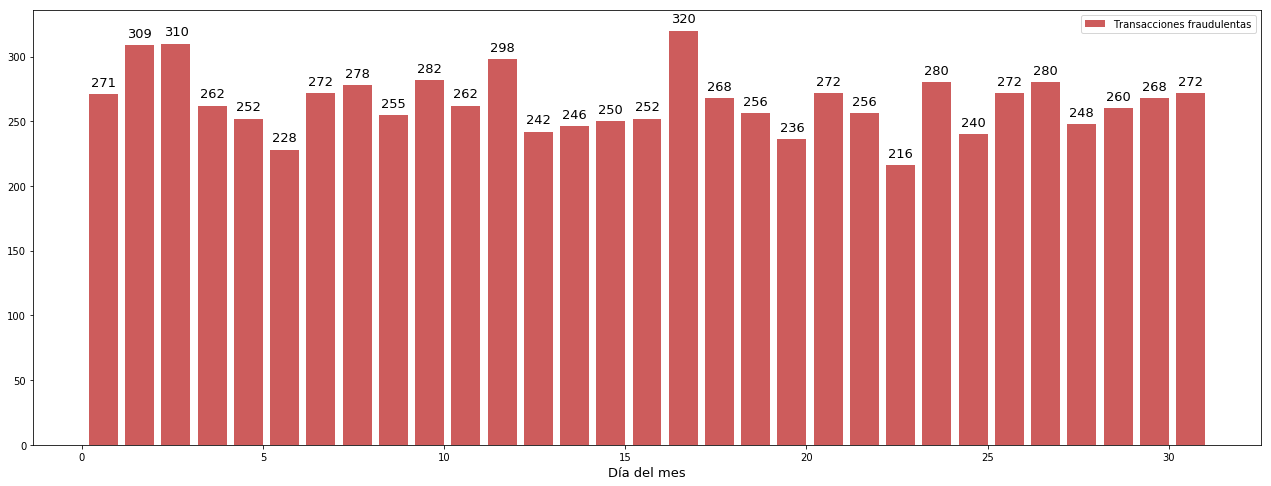

In [9]:
# Calculamos el volumen de transacciones con fraude por dia del mes
x = df.loc[df["isFraud"] == 1]
Fraud_Transactions = x[['day','amount']].groupby(['day']).count()
Fraud_Transactions

# tamaño de cada barra
width = 0.8

fig, ax = plt.subplots(figsize=(22,8))

#Generamos las barras para el conjunto Fraud_Transactions
rects1 = ax.bar(Fraud_Transactions.index - width/2, Fraud_Transactions["amount"], width, label = 'Transacciones fraudulentas', color = 'indianred')

#Añadimos un legen() esto permite mostrar con colores las categorias
ax.legend()

#Añadimos etiqueta al eje X
plt.xlabel("Día del mes", fontsize = 13)

#funcion que permite añadir etiquetas de manera individual a cada barra
def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 13)
        

#Añadimos las etiquetas para cada barra
autolabel(rects1)

#Mostramos la grafica con el metodo show()
plt.show()

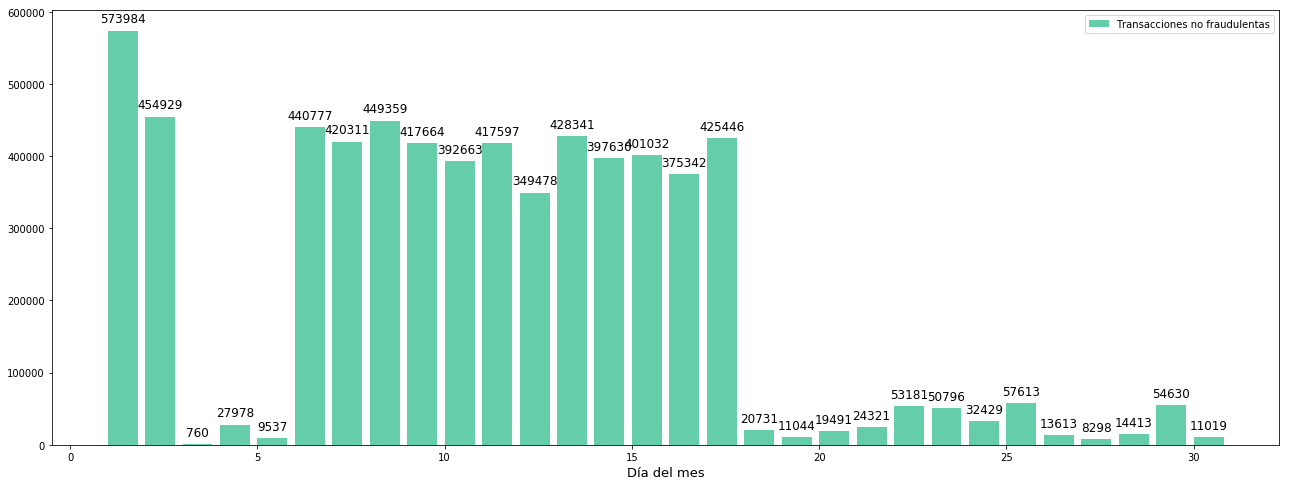

In [10]:
# Calculamos el volumen de transacciones no fraudulentas por dia del mes
y = df.loc[df["isFraud"] == 0]
Not_Fraud_Transactions = y[['day','amount']].groupby(['day']).count()
Not_Fraud_Transactions

# tamaño de cada barra
width = 0.8

fig, ax = plt.subplots(figsize=(22,8))

#Generamos las barras para el conjunto Not_Fraud_Transactions
rects2 = ax.bar(Not_Fraud_Transactions.index + width/2, Not_Fraud_Transactions["amount"], width, label = 'Transacciones no fraudulentas', color = 'mediumaquamarine')

#Añadimos un legen() esto permite mostrar con colores las categorias
ax.legend()

#Añadimos etiqueta al eje X
plt.xlabel("Día del mes", fontsize = 13)

#funcion que permite añadir etiquetas de manera individual a cada barra
def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 12)

#Añadimos las etiquetas para cada barra
autolabel(rects2)

#Mostramos la grafica con el metodo show()
plt.show()

**CONCLUSIÓN**: Como se observa en los gráficos, las 8.213 transacciones de tipo fraudulento se distribuyen de una forma constante durante el mes de estudio. En este caso, no se observa un patrón para las variables de tipo fraudulento. Sin embargo, para las transacciones no fraudulentas, se observa que la mayoría de ellas se realizan en los 18 primeros días del mes. 

**¿Cómo se distribuye el volumen de transacciones fraudulentas y no fraudulentas en las horas del día?**

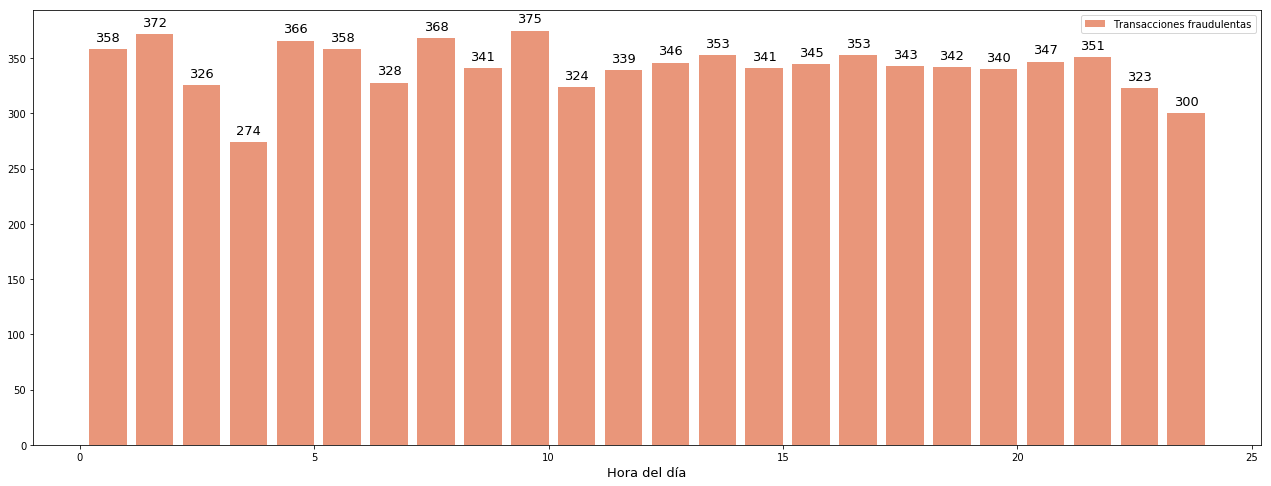

In [11]:
# Calculamos el volumen de transacciones con fraude por dia del mes
x = df.loc[df["isFraud"] == 1]
Fraud_Transactions = x[['hours_day','amount']].groupby(['hours_day']).count()
Fraud_Transactions

# tamaño de cada barra
width = 0.8

fig, ax = plt.subplots(figsize=(22,8))

#Generamos las barras para el conjunto Fraud_Transactions
rects1 = ax.bar(Fraud_Transactions.index - width/2, Fraud_Transactions["amount"], width, label = 'Transacciones fraudulentas', color = 'darksalmon')

#Añadimos un legen() esto permite mostrar con colores las categorias
ax.legend()

#Añadimos etiqueta al eje X
plt.xlabel("Hora del día", fontsize = 13)

#funcion que permite añadir etiquetas de manera individual a cada barra
def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 13)
        

#Añadimos las etiquetas para cada barra
autolabel(rects1)

#Mostramos la grafica con el metodo show()
plt.show()

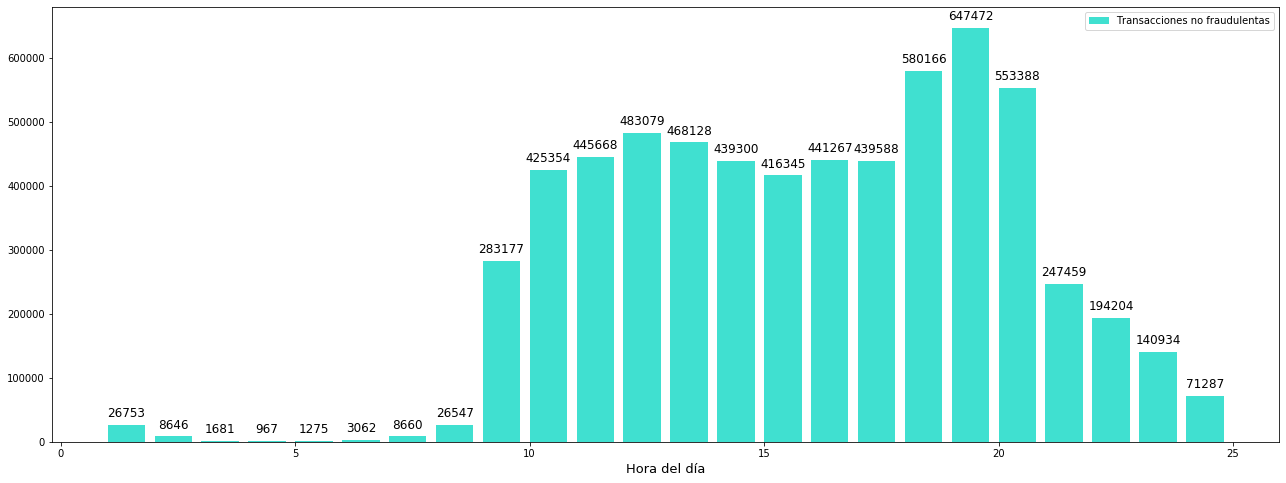

In [7]:
# Calculamos el volumen de transaccion sin fraude por dia del mes
y = df.loc[df["isFraud"] == 0]
Not_Fraud_Transactions = y[['hours_day','amount']].groupby(['hours_day']).count()
Not_Fraud_Transactions

# tamaño de cada barra
width = 0.8

fig, ax = plt.subplots(figsize=(22,8))

#Generamos las barras para el conjunto Not_Fraud_Transactions
rects2 = ax.bar(Not_Fraud_Transactions.index + width/2, Not_Fraud_Transactions["amount"], width, label = 'Transacciones no fraudulentas', color = 'turquoise')

#Añadimos un legen() esto permite mostrar con colores las categorias
ax.legend()

#Añadimos etiqueta al eje X
plt.xlabel("Hora del día", fontsize = 13)

#funcion que permite añadir etiquetas de manera individual a cada barra
def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 12)

#Añadimos las etiquetas para cada barra
autolabel(rects2)

#Mostramos la grafica con el metodo show()
plt.show()

**CONCLUSIÓN**: Como se observa en los gráficos, no se identifica patrón para las transacciones fraudulentas. Sin embargo, para las transacciones no fraudulentas, se observa que principalmente, éstas se realizan entre las 9:00am y las 08:00pm del día. Al comprobar la proporción de transacciones de cada tipo según la franja horaria:

In [12]:
hours_day = df["hours_day"]

min_hours = df["hours_day"].min()
max_hours = df["hours_day"].max()
eps = 0.00001
# tramos
bins = [min_hours - eps, 8, 16, max_hours + eps]
# categorizamos conla función cut
df['hours_block'] = pd.cut(hours_day, bins, include_lowest=True)

# Calculamos la proporcion
df2 = df[['hours_block','isFraud', 'step']]
df1 = df2.groupby(['hours_block', 'isFraud']).agg('count')
level_fraude = df1.groupby(['isFraud']).agg({'step' : 'sum'})
df1.div(level_fraude, level='isFraud') * 100

step
hours_block  isFraud           
(0.999, 8.0] 0.0       1.221058
             1.0      33.483502
(8.0, 16.0]  0.0      53.542652
             1.0      33.653963
(16.0, 24.0] 0.0      45.236290
             1.0      32.862535

Mientras que en el caso de las transacciones fraudulentas existe la misma proporción de transacciones en las tres franjas horarias, para las transacciones no fraudulentas solo existe un 1,22% de los casos que se realizan entre las 1:00h - 08:00h.

### Matriz de correlacciones
Un aspecto importante es la correlación que pueda haber entre las variables, lo cual lo podemos visualizar de la siguiente manera (para los predictores):

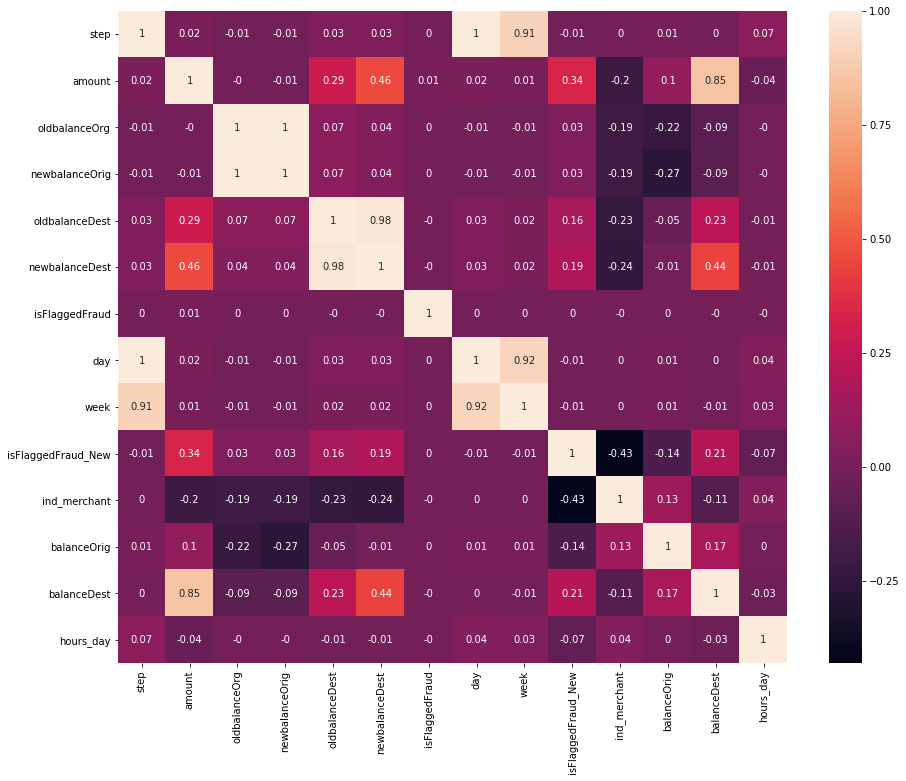

In [8]:
mydata_X = df.drop('isFraud', axis=1)

correlation_matrix = mydata_X.corr().round(2)
plt.subplots(figsize=(15,12))
cor = sns.heatmap(data=correlation_matrix, annot=True)

Como se observa, existe una fuerte dependencia entre las variables *newbalanceOrig* y *oldbalanceOrig* y entre *newbalanceDest* y *oldbalanceDest*. Estas relaciones de dependencia lineal entre las variables tienen sentido ya que suponen el aumento/disminución del balance se realiza sobre la misma cuenta móvil. Además, también existe una dependencia de 1 entre la variable *day* y *step* ya que ambas variables contienen la misma información en diferente escala y entre la variable *day* y week puesto que las dos recogen información de tiempo. Además, comprobamos que la variable *isFlaggedFraud* tiene poco poder predictivo puesto que es una variable que aporta muy poca información en el dataframe (total(1)'s: 16), por lo que el coeficiente de correlación de pearson no es capaz de encontrar relación entre esa variable y el resto de predictores.

De cara a la realización del modelo predictivo, se tendrá en cuenta el resultado de la matriz de correlaciones para realizar la disminución de la dimensión del dataframe de entrada al modelo.

## Exportamos el Notebook
Exportamos el Notebook a formato HTML:

In [10]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = '3b_discovery_nuevas_variables.ipynb'
output_file_name = '3b_discovery_nuevas_variables.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)